##Prediksi Biaya Asuransi dengan Regresi
Proyek ini bertujuan untuk memprediksi besarnya biaya asuransi (`charges`) berdasarkan karakteristik pelanggan seperti usia, BMI, status perokok, dll, menggunakan algoritma machine learning regresi.

Nama : Fika Saputri
MC206D5X0930.



## Data Understanding

Dataset berisi informasi pelanggan asuransi, terdiri dari 1338 sampel dan 7 kolom utama:
- `age`: usia nasabah
- `sex`: jenis kelamin
- `bmi`: indeks massa tubuh
- `children`: jumlah anak yang ditanggung
- `smoker`: status perokok
- `region`: lokasi tempat tinggal
- `charges`: total biaya asuransi

## Data Loading
Tahapan ini memuat data menggunakan pandas dan menampilkan beberapa baris awal untuk memastikan data berhasil di-load.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis


### Deskripsi Statistik & Tipe Data
Melihat struktur dataset menggunakan `df.info()` dan `df.describe()` untuk mengetahui tipe data, ukuran dataset, serta statistik deskriptif dari setiap fitur. Juga dilakukan pengecekan jumlah nilai unik pada tiap kolom untuk memastikan variasi data.

### Missing Value & Outlier
Dataset dicek menggunakan `df.isnull().sum()` dan tidak ditemukan missing value. Selain itu, dilakukan deteksi outlier dengan metode IQR (Interquartile Range) pada fitur numerik seperti `age`, `bmi`, `children`, dan `charges`.

Penanganan outlier dilakukan dengan:
- **Winsorization** pada kolom `bmi` untuk membatasi nilai ekstrim.
- **Penghapusan outlier** pada kolom `charges`, dikelompokkan berdasarkan status `smoker`, untuk mencegah bias pada model regresi.

Juga dilakukan pengecekan dan penghapusan data duplikat menggunakan `df.duplicated().sum()`.

### Analisis Univariat
Visualisasi dilakukan untuk melihat distribusi tiap variabel secara individual:
- Histogram untuk kolom `age` dan `charges`.
- Boxplot pada `bmi` untuk melihat penyebaran dan outlier.
- Countplot pada kolom kategorikal seperti `smoker`.
- Distribusi biaya asuransi (`charges`) dilihat dengan histogram dan KDE.

### Analisis Multivariat
Hubungan antar fitur dianalisis menggunakan:
- Heatmap korelasi untuk fitur numerik seperti `age`, `bmi`, `children`, dan `charges`.
- Boxplot `charges` berdasarkan `smoker` menunjukkan bahwa perokok cenderung memiliki biaya lebih tinggi.
- Scatter plot antara `bmi` dan `charges` menunjukkan hubungan yang lebih kuat pada kelompok perokok.
- Barplot `charges` terhadap `region` untuk melihat perbedaan rata-rata biaya di masing-masing wilayah.

Hasil EDA menunjukkan bahwa fitur seperti `smoker`, `bmi`, dan `age` memiliki pengaruh signifikan terhadap `charges`.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [6]:
# Statistik deskriptif
print(df.describe(include='all'))

                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    

In [7]:
# Cek jumlah unique value di setiap kolom
print(df.nunique())

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [8]:
# Cek missing value
print("Missing values:\n", df.isnull().sum())

# Deteksi outlier menggunakan IQR untuk kolom numerik
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

# Cek outlier untuk setiap kolom numerik
num_cols = ['age', 'bmi', 'children', 'charges']
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

# (Optional) Hilangkan outlier jika diperlukan
# df = df[~df.index.isin(outliers.index)]


Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


In [9]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_bmi = detect_outliers_iqr(df, 'bmi')
outliers_charges = detect_outliers_iqr(df, 'charges')

print(f"Outliers pada BMI: {len(outliers_bmi)}")
print(f"Outliers pada Charges: {len(outliers_charges)}")


Outliers pada BMI: 9
Outliers pada Charges: 139


In [10]:
# Cek baris duplikat
# df.duplicate() # Baris ini menghasilkan error
print(f"Jumlah baris duplikat: {df.duplicated().sum()}")

Jumlah baris duplikat: 1


In [11]:
df.drop_duplicates(inplace=True)


In [12]:
# Winsorization contoh sederhana:
import numpy as np

Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['bmi'] = np.where(df['bmi'] > upper, upper,
                     np.where(df['bmi'] < lower, lower, df['bmi']))


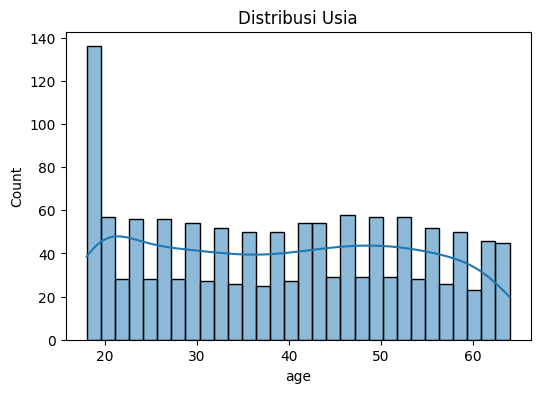

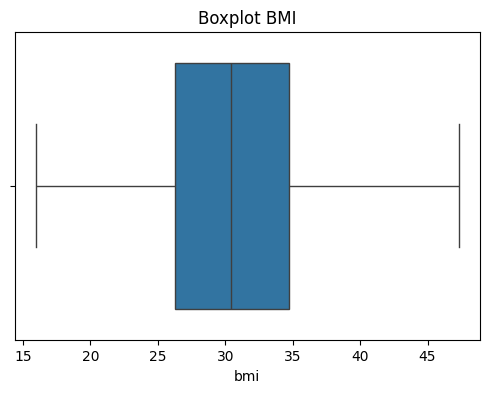

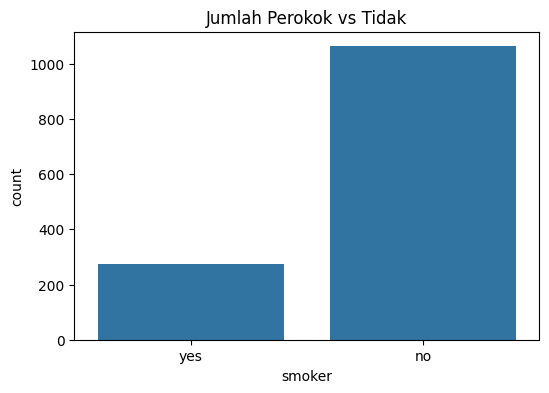

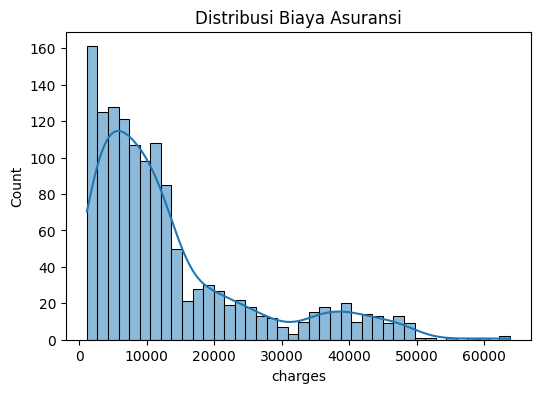

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram usia
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribusi Usia')
plt.show()

# Boxplot BMI
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['bmi'])
plt.title('Boxplot BMI')
plt.show()

# Countplot smoker
plt.figure(figsize=(6, 4))
sns.countplot(x='smoker', data=df)
plt.title('Jumlah Perokok vs Tidak')
plt.show()

# Distribusi Charges
plt.figure(figsize=(6, 4))
sns.histplot(df['charges'], bins=40, kde=True)
plt.title('Distribusi Biaya Asuransi')
plt.show()


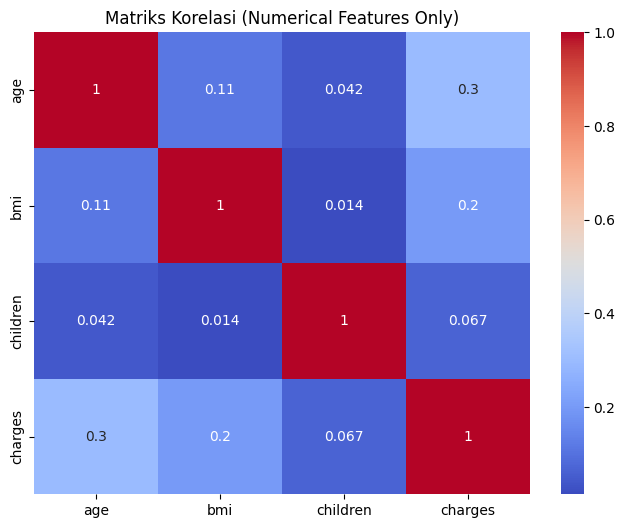

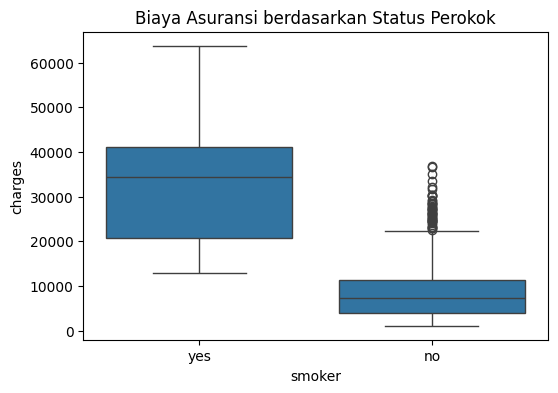

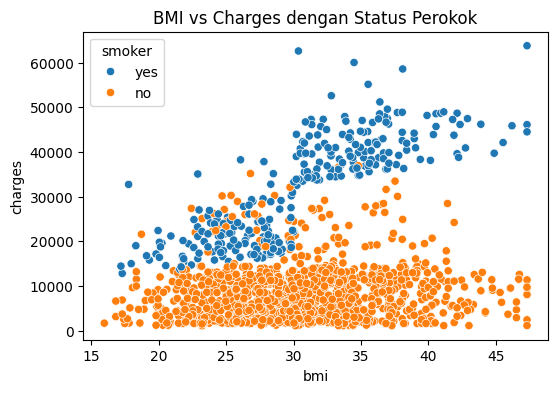

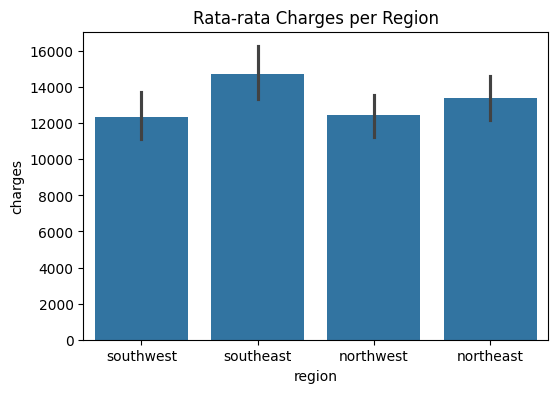

In [14]:
# Korelasi antar fitur numerik
plt.figure(figsize=(8, 6))

# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

# Calculate and plot the heatmap on the numerical data
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi (Numerical Features Only)')
plt.show()

# Charges berdasarkan status perokok
plt.figure(figsize=(6, 4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Biaya Asuransi berdasarkan Status Perokok')
plt.show()

# Scatter plot BMI vs Charges
plt.figure(figsize=(6, 4))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('BMI vs Charges dengan Status Perokok')
plt.show()

# Charges berdasarkan Region
plt.figure(figsize=(6, 4))
sns.barplot(x='region', y='charges', data=df)
plt.title('Rata-rata Charges per Region')
plt.show()

Sebelum: 1337 baris
Sesudah: 1291 baris (tanpa outlier)


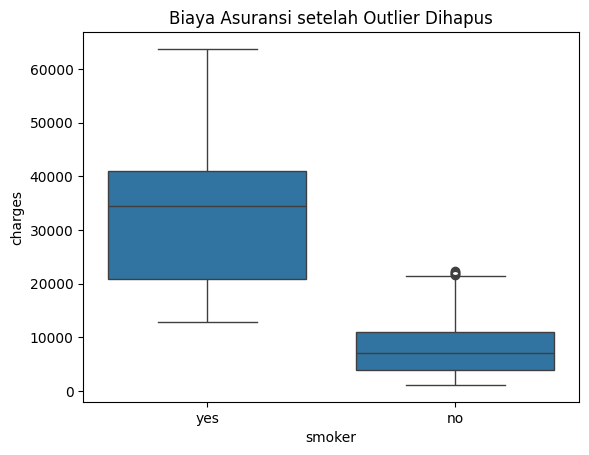

In [15]:
import pandas as pd

# Fungsi untuk menghapus outlier berdasarkan kolom charges
def remove_outliers_iqr(df, group_col='smoker', target_col='charges'):
    cleaned_df = pd.DataFrame()

    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        Q1 = subset[target_col].quantile(0.25)
        Q3 = subset[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        filtered = subset[(subset[target_col] >= lower_bound) & (subset[target_col] <= upper_bound)]
        cleaned_df = pd.concat([cleaned_df, filtered], ignore_index=True)

    return cleaned_df

# Terapkan fungsi
df_cleaned = remove_outliers_iqr(df, group_col='smoker', target_col='charges')

# Cek sebelum dan sesudah
print(f"Sebelum: {df.shape[0]} baris")
print(f"Sesudah: {df_cleaned.shape[0]} baris (tanpa outlier)")

# Opsional: plot ulang tanpa outlier
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='smoker', y='charges', data=df_cleaned)
plt.title("Biaya Asuransi setelah Outlier Dihapus")
plt.show()


## Data Preparation

### Encoding Fitur Kategorikal
Fitur kategorikal diolah agar dapat digunakan dalam model machine learning:
- Kolom biner seperti `sex` dan `smoker` diubah menggunakan **Label Encoding** (`male` → 1, `female` → 0; `yes` → 1, `no` → 0).
- Kolom `region` dengan lebih dari dua kategori diubah menggunakan **One-Hot Encoding**, dan parameter `drop_first=True` digunakan untuk menghindari multikolinearitas.

### Split Data
Dataset dipisahkan menjadi:
- **Fitur (X):** Semua kolom kecuali `charges` (sebagai target).
- **Target (y):** Kolom `charges`.

Pembagian data dilakukan menjadi **80% data latih** dan **20% data uji** menggunakan `train_test_split` dengan `random_state=42` untuk menjaga reproducibility.

### Feature Scaling
Untuk meningkatkan performa model yang sensitif terhadap skala (seperti KNN dan regresi linier), dilakukan normalisasi fitur numerik (`age`, `bmi`, `children`) menggunakan **StandardScaler**:
- `X_train` dilakukan **fit dan transform**.
- `X_test` hanya **transform**, menggunakan statistik dari data latih untuk menghindari data leakage.

Setelah tahap ini, data siap untuk dimodelkan.


In [16]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding untuk kolom biner
label_enc = LabelEncoder()
df['sex'] = label_enc.fit_transform(df['sex'])       # male:1, female:0
df['smoker'] = label_enc.fit_transform(df['smoker']) # yes:1, no:0
# One-Hot Encoding untuk 'region'
df = pd.get_dummies(df, columns=['region'], drop_first=True)
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


##Train-Test-Split

In [17]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur (X) dan target (y)
X = df.drop(columns='charges')  # Semua kolom kecuali 'charges'
y = df['charges']               # Target

# Bagi data menjadi data latih dan data uji (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Cek dimensi data hasil split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1069, 8)
X_test shape: (268, 8)
y_train shape: (1069,)
y_test shape: (268,)


##Standarisasi

In [18]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi scaler
scaler = StandardScaler()

# Identifikasi kolom numerik
numeric_features = ['age', 'bmi', 'children']

# Fit dan transform pada X_train
X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Transform juga X_test
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Cek hasil
print(X_train_scaled.head())


           age  sex       bmi  children  smoker  region_northwest  \
1114 -1.157680    1 -1.002462 -0.907908       0             False   
968  -1.300619    1 -0.796635  0.766904       0             False   
599   0.914926    0  1.166632  0.766904       0              True   
170   1.701087    1  1.824110 -0.907908       0             False   
275   0.557580    0 -0.654140  0.766904       0             False   

      region_southeast  region_southwest  
1114             False             False  
968              False             False  
599              False             False  
170               True             False  
275              False             False  


## Modeling

### Pemilihan Model
Beberapa algoritma regresi diuji untuk memprediksi `charges`, yaitu:
- **K-Nearest Neighbors (KNN):** Algoritma berbasis instance yang memprediksi nilai berdasarkan tetangga terdekat.
- **Linear Regression:** Model linear dasar untuk regresi.
- **Random Forest Regressor:** Model ensemble berbasis decision tree yang menggunakan bagging.
- **Gradient Boosting Regressor:** Model ensemble berbasis boosting yang membangun model secara bertahap untuk meningkatkan akurasi.

### Evaluasi Awal
Model dievaluasi menggunakan metrik **Mean Squared Error (MSE)** pada data latih dan data uji untuk mengetahui performa dan potensi overfitting.

Semua model dilatih menggunakan data yang telah dipreparasi sebelumnya (`X_train`, `y_train`), dan performanya diukur pada data latih dan uji.


In [48]:
models = pd.DataFrame(index=['train_mse', 'test_mse'])

##KNN

In [49]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

models.loc['train_mse', 'KNN'] = mean_squared_error(y_train, knn.predict(X_train))
models.loc['test_mse', 'KNN'] = mean_squared_error(y_test, knn.predict(X_test))


# Linear Regression

In [50]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

models.loc['train_mse', 'Linear'] = mean_squared_error(y_train, linear_model.predict(X_train))
models.loc['test_mse', 'Linear'] = mean_squared_error(y_test, linear_model.predict(X_test))


##Random Forest

In [51]:
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train, y_train)

models.loc['train_mse', 'Random Forest'] = mean_squared_error(y_train, RF.predict(X_train))
models.loc['test_mse', 'Random Forest'] = mean_squared_error(y_test, RF.predict(X_test))


##Boosting Algorithm

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

boosting = GradientBoostingRegressor(random_state=42)
boosting.fit(X_train, y_train)

models.loc['train_mse', 'Boosting'] = mean_squared_error(y_train, boosting.predict(X_train))
models.loc['test_mse', 'Boosting'] = mean_squared_error(y_test, boosting.predict(X_test))

## Evaluation

### Metode Evaluasi
Model dievaluasi menggunakan beberapa metrik regresi berikut:

- **MAE (Mean Absolute Error):** Rata-rata selisih absolut antara nilai aktual dan prediksi.
- **RMSE (Root Mean Squared Error):** Akar dari selisih kuadrat rata-rata — sensitif terhadap outlier.
- **R² Score (Koefisien Determinasi):** Menunjukkan seberapa baik variabel independen menjelaskan variasi target.

### Hasil Evaluasi Model

| Model              | Train MAE | Test MAE | Train RMSE | Test RMSE | Train R² | Test R² |
|--------------------|-----------|----------|------------|-----------|----------|---------|
| Linear Regression  | 4,186.07  | 4,181.90 | 6,080.12   | 5,954.23  | 0.73     | 0.81    |
| KNN                | 3,935.42  | 5,053.66 | 6,466.54   | 8,478.27  | 0.69     | 0.61    |
| Random Forest      | 1,060.30  | 2,634.58 | 1,892.53   | 4,695.55  | 0.97     | 0.88    |
| Boosting           | 2,107.04  | 2,471.72 | 3,846.43   | 4,229.62  | 0.89     | 0.90    |

### Analisis & Insight

- 🔹 **Linear Regression** memberikan hasil yang cukup seimbang antara train dan test. Meski tidak paling akurat, model ini **stabil** dan tidak overfitting. Cocok jika interpretabilitas tinggi dibutuhkan.
  
- 🔹 **KNN** memiliki **RMSE tertinggi pada data uji**, menunjukkan performa buruk saat generalisasi. Model ini kurang cocok untuk data ini.

- 🔹 **Random Forest** menunjukkan **R² sangat tinggi di train (0.97)** tetapi lebih rendah di test (0.88), menandakan adanya **overfitting ringan**.

- 🔹 **Gradient Boosting** memiliki performa paling **seimbang dan akurat**, dengan Test RMSE rendah dan R² Test tertinggi (0.90). Ini menjadikan Boosting sebagai kandidat **terbaik** secara keseluruhan untuk prediksi biaya medis (`charges`).

### Visualisasi MSE

```python
# Visualisasi MSE antar model
ax = mse.plot(kind='bar', figsize=(10, 6), zorder=3)
ax.grid(axis='y', zorder=0, linestyle='--', alpha=0.7)
ax.set_title("Train vs Test MSE per Model", fontsize=14)
ax.set_xlabel("Model")
ax.set_ylabel("Mean Squared Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [54]:
# Inisialisasi list untuk menyimpan hasil evaluasi
eval_results = []

# Dictionary model
model_dict = {
    'Linear Regression': linear_model,
    'KNN': knn,
    'Random Forest': RF,
    'Boosting': boosting
}

# Evaluasi setiap model
for name, model in model_dict.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    eval_results.append({
        'Model': name,
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    })


In [55]:
eval_df = pd.DataFrame(eval_results)

# Format angka agar lebih rapi
pd.options.display.float_format = '{:,.2f}'.format

# Tampilkan hasil evaluasi
print(eval_df)


               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   4,186.07  4,181.90    6,080.12   5,954.23      0.73   
1                KNN   3,935.42  5,053.66    6,466.54   8,478.27      0.69   
2      Random Forest   1,060.30  2,634.58    1,892.53   4,695.55      0.97   
3           Boosting   2,107.04  2,471.72    3,846.43   4,229.62      0.89   

   Test R2  
0     0.81  
1     0.61  
2     0.88  
3     0.90  


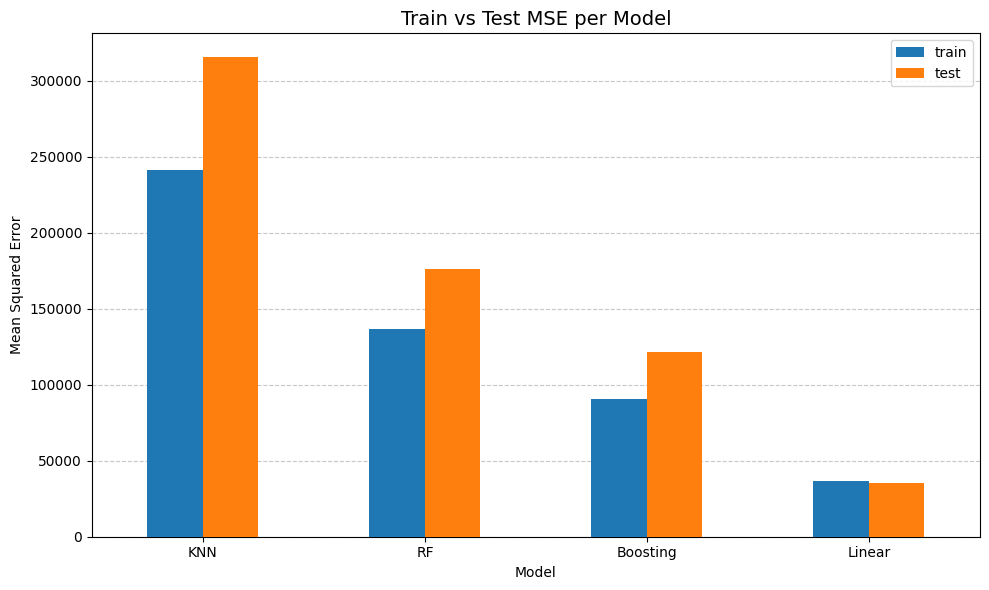

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Data MSE sesuai data kamu
mse_data = {
    'train': {
        'KNN': 241481.694777,
        'RF': 136870.444235,
        'Boosting': 90357.730633,
        'Linear': 36967.806616
    },
    'test': {
        'KNN': 315332.936185,
        'RF': 176232.735501,
        'Boosting': 121391.191979,
        'Linear': 35452.902114
    }
}

# Buat DataFrame
mse = pd.DataFrame(mse_data)

# Plot grouped bar chart
ax = mse.plot(kind='bar', figsize=(10, 6), zorder=3)

# Tambahkan grid dan label
ax.grid(axis='y', zorder=0, linestyle='--', alpha=0.7)
ax.set_title("Train vs Test MSE per Model", fontsize=14)
ax.set_xlabel("Model")
ax.set_ylabel("Mean Squared Error")
plt.xticks(rotation=0)

# Tampilkan plot
plt.tight_layout()
plt.show()


## Kesimpulan
Berdasarkan evaluasi 4 model regresi, Gradient Boosting memberikan performa terbaik dengan skor R² tertinggi di data uji (0.90) dan RMSE terendah. Model ini dipilih sebagai model akhir untuk memprediksi biaya medis (`charges`).
